# Logic ODE tutorial

Short tutorial to show how to use the logic ODE module. 

In [1]:
from codax.nn_cno import ode
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sympy2jax
import jax
jax.__version__, sympy2jax.__version__

('0.3.25', '0.1.0')

Similarly to cellnopt, the data is loaded from MIDAS files and the prior knowledge is loaded from SIF file. 

In [3]:
c = ode.logicODE("../codax/nn_cno/datasets/working_case_study/PKN-test.sif",
    "../codax/nn_cno/datasets/working_case_study/MD-test.csv")

WARNING [jax._src.lib.xla_bridge:360]:  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
WARNING [jax._src.lib.xla_bridge:360]:  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


After importing, we preprocess the model and data. We use the default arguments. 
It is adviceable to keep the expansion False for logic ODEs, since in logicODEs the model edges are not eliminated, so after expansion the effect of AND and OR gates would be both present. 

In [4]:
c.preprocessing(compression=True,cutnonc=True,expansion=False)

Next, we plot the model and the experimental data. 
This is a good way to check that the model and data are correctly loaded.

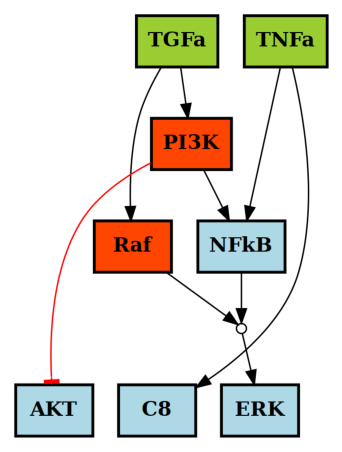

In [5]:
c.plot_model()

Blue nodes are measured nodes, green nodes are stimuli and red nodes are inhibited nodes (in certain experimental conditions). AND gates are represented by a black circle, we consider OR gates for the multiple incoming edges on a node (eg. NFkB).
Arrows represents activation edges, T-shaped edges represent inhibition edges. 

/home/pablo/miniconda3/envs/codax/lib/python3.8/site-packages/codax/nn_cno/io/midas.py:2525: RuntimeWarning: invalid value encountered in true_divide
  return self.values / float(self.values.max())
/home/pablo/miniconda3/envs/codax/lib/python3.8/site-packages/codax/nn_cno/io/midas.py:2652: RuntimeWarning: All-NaN axis encountered
  if np.isnan(np.nanmax(values)):


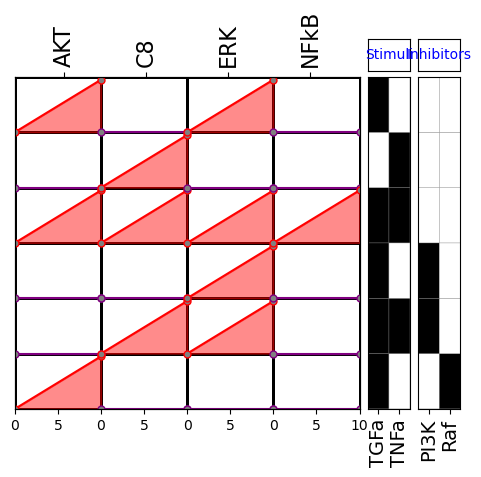

In [6]:
c.plot_midas()

We can also have a look at the numerical value of the data: 

In [7]:
c.midas.df

AKT  C8  ERK  NFkB
cell experiment   time                    
test experiment_0 0       0   0    0     0
                  10      1   0    1     0
     experiment_1 0       0   0    0     0
                  10      0   1    0     0
     experiment_2 0       0   0    0     0
                  10      1   1    1     1
     experiment_3 0       0   0    0     0
                  10      0   0    1     0
     experiment_4 0       0   0    0     0
                  10      0   1    1     0
     experiment_5 0       0   0    0     0
                  10      1   0    0     0

Get the initial model parameters: 

In [8]:
c.get_ODEparameters()

{'PI3K_k_AKT': 1.0,
 'PI3K_n_AKT': 2.0,
 'tau_AKT': 0.1,
 'TNFa_k_C8': 1.0,
 'TNFa_n_C8': 2.0,
 'tau_C8': 0.1,
 'NFkB_k_ERK': 1.0,
 'NFkB_n_ERK': 2.0,
 'Raf_k_ERK': 1.0,
 'Raf_n_ERK': 2.0,
 'tau_ERK': 0.1,
 'PI3K_k_NFkB': 1.0,
 'PI3K_n_NFkB': 2.0,
 'TNFa_k_NFkB': 1.0,
 'TNFa_n_NFkB': 2.0,
 'tau_NFkB': 0.1,
 'TGFa_k_PI3K': 1.0,
 'TGFa_n_PI3K': 2.0,
 'tau_PI3K': 0.1,
 'TGFa_k_Raf': 1.0,
 'TGFa_n_Raf': 2.0,
 'tau_Raf': 0.1}

Fit the model to the data:

In [9]:
opt_params = c.fit(max_iter=350)

  iter  	 current loss 	 min. loss	 grad norm
  0     	 1.5120e-01 	 1.5120e-01 	 3.1316e-01
  10    	 1.1703e-01 	 1.1703e-01 	 9.9148e-02
  20    	 1.0810e-01 	 1.0810e-01 	 9.3336e-02
  30    	 1.0331e-01 	 1.0331e-01 	 8.1660e-02
  40    	 9.9472e-02 	 9.9472e-02 	 6.1472e-02
  50    	 9.5082e-02 	 9.5082e-02 	 2.7459e-02
  60    	 8.8734e-02 	 8.8734e-02 	 7.2535e-02
  70    	 7.8367e-02 	 7.8367e-02 	 7.8934e-02
  80    	 1.0180e-01 	 7.5709e-02 	 1.1610e+02
  90    	 6.5775e+01 	 7.5709e-02 	 5.1267e+03
  iter  	 current loss 	 min. loss	 grad norm
  100   	 3.9384e+01 	 7.5709e-02 	 3.9657e+03
  110   	 3.1988e+00 	 7.5709e-02 	 1.1191e+03
  120   	 6.9946e-01 	 7.5709e-02 	 5.0274e+02
  130   	 1.5974e+00 	 7.5709e-02 	 7.8230e+02
  140   	 6.5889e-01 	 6.9932e-02 	 4.8644e+02
  150   	 1.3329e-01 	 6.8595e-02 	 1.6255e+02
  160   	 6.7721e-02 	 6.7721e-02 	 1.5299e+01
  170   	 7.8798e-02 	 6.7721e-02 	 6.8532e+01
  180   	 7.6278e-02 	 6.7183e-02 	 6.0966e+01
  190   	 7.044

Run the simulation with the fitted parameters. We also increase the time resolution.

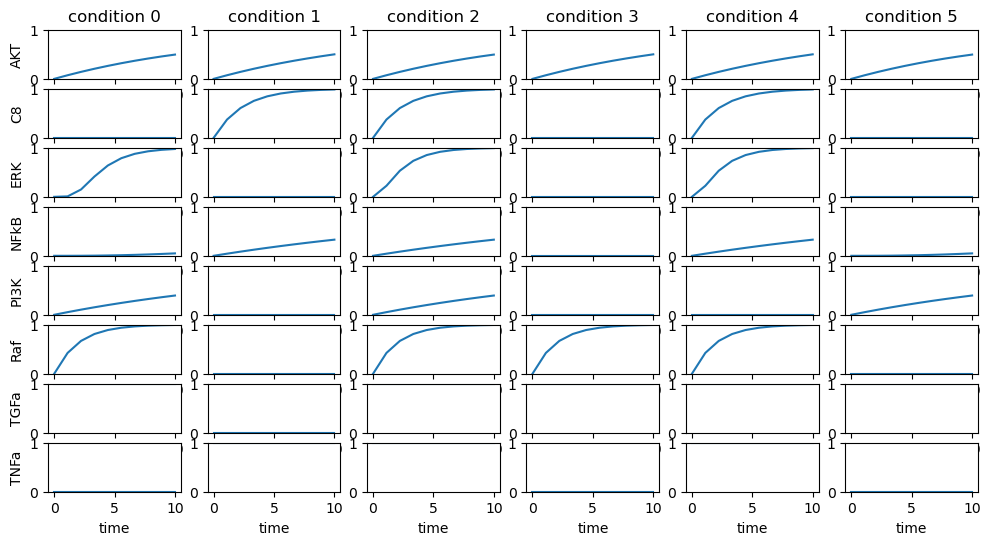

In [10]:
sim_res = c.simulate( ODEparameters=opt_params, timepoints=jax.numpy.linspace(0,10,10), plot_simulation=True)

# TODOs

- [ ] Change the model parameters
- [ ] Explore and change the initial conditions of the ODEs
- [ ] change the transfer functions
- [ ] plot some diagnostics with the transfer functions and the model parameters
- [ ] Illustrate changing bounds of the parameters
- [ ] Plot model fitness (simulation and data)
- [ ] Illustrate how to use optimizer from pyPESTO